# House_Price_Prediction — Global Forecasting LightGBM

In [147]:
!pip install darts

In [148]:
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] =False

In [428]:
import os
                        
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, StaticCovariatesTransformer
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.metrics import rmsle
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm.notebook import tqdm_notebook

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

# 1. Data Preprocessing

In [150]:
# helper function to print messages
def cprint(title, *args):
    print(
        "="*len(title), title, "="*len(title),
        *args,
        sep="\n",
    )

### Loading the datasets.

In [429]:
PATH = r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data"

train = pd.read_csv(os.path.join(PATH, "train.csv")) # (1118822, 52)
test = pd.read_csv(os.path.join(PATH, "test.csv")) # (9272, 51)
train_test = pd.read_csv(os.path.join(PATH, "train_test.csv")) # (1128094, 53)
subway_feature = pd.read_csv(os.path.join(PATH, "subway_feature.csv"))
sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
bus_feature = pd.read_csv(os.path.join(PATH, "bus_feature.csv"))
seoul_apart = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\seoul_apart.csv", encoding='utf-8') # (2792, 47)
# 출처: https://data.seoul.go.kr/dataList/OA-15818/S/1/datasetView.do 서울시 공동주택 아파트 정보
doroaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\doroaddress.csv", encoding='utf-8') # (8325, 7)
bunjiaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\bunjiaddress.csv", encoding='utf-8') # (8954, 1) 
# 출처: https://www.juso.go.kr/CommonPageLink.do?link=/support/AddressTransform 100만건 이하 주소전환

C:\Users\user\AppData\Local\Temp\ipykernel_22368\3151250873.py:3: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(os.path.join(PATH, "train.csv")) # (1118822, 52)
C:\Users\user\AppData\Local\Temp\ipykernel_22368\3151250873.py:5: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train_test = pd.read_csv(os.path.join(PATH, "train_test.csv")) # (1128094, 53)


## read_csv 만들기 위한 데이터전처리 과정 --> 완료

### bunjiaddress

In [ ]:
import pandas as pd

# Assuming 'train_test' is your DataFrame
# Extract unique values from '번지주소' column and convert them to a DataFrame
unique_addresses = pd.DataFrame(train_test['번지주소'].unique(), columns=['Unique Addresses'])

# Save to a CSV file with cp949 encoding, no index, and no header
unique_addresses.to_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\번지주소.txt", encoding='cp949', index=False, header=False)


In [ ]:
doroaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\도로명주소.txt", encoding='cp949') # 
bunjiaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\번지주소.txt", encoding='cp949') # 

doroaddress.to_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\도로명주소.txt", encoding='utf-8', index=False)
bunjiaddress.to_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\번지주소.txt", encoding='utf-8', index=False)


In [152]:
bunjiaddress.rename(columns={0:'번지주소'}, inplace=True)

In [153]:
bunjiaddress = bunjiaddress.drop(bunjiaddress.columns[0], axis=1)

In [ ]:
bunjiaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\번지주소.txt", encoding='cp949', header=None) #  


In [ ]:
bunjiaddress.to_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\bunjiaddress.csv", index=False)

In [245]:
bunjiaddress

,번지주소
0,서울특별시 강남구 개포동 658-1
1,서울특별시 강남구 개포동 652
2,서울특별시 강남구 개포동 12-2
3,서울특별시 강남구 개포동 141
4,서울특별시 강남구 개포동 187
...,...
8949,서울특별시 동작구 흑석동 253-89
8950,서울특별시 마포구 신수동 400-1
8951,서울특별시 성동구 송정동 67-5
8952,서울특별시 중구 인현동2가 240


In [246]:
bunjiaddress[bunjiaddress['번지주소'].isna()]

,번지주소
3578,NaN


In [ ]:
bunjiaddress.drop()

### doroaddress

In [ ]:
column_names = ['결과코드', '우편번호', '지번주소', '도로명주소', '건물관리번호']
doroaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\도로명주소.txt", delimiter=';', names=column_names, on_bad_lines='warn')

In [ ]:
doroaddress = doroaddress.drop(doroaddress.index[0])

In [ ]:
doroaddress = doroaddress.drop(doroaddress.columns[0], axis=1)

In [405]:
doroaddress.to_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\doroaddress.csv", index=False)

In [221]:
doroaddress['동'] = doroaddress['도로명주소'].str.extract(r'\((.*?)\)')

In [223]:
doroaddress['도로명주소'] = doroaddress['도로명주소'].str.replace(r'\s*\(.*?\)', '', regex=True)

In [310]:
print(doroaddress['우편번호'].dtype)

float64


In [403]:
doroaddress

,결과코드,우편번호,지번주소,도로명주소,건물관리번호,동,동도로명주소
0,전환성공,6316.0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,1168010300106580001019759,개포동,서울특별시 강남구 개포동 언주로 3
1,전환성공,6319.0,서울특별시 강남구 개포동 652,서울특별시 강남구 개포로 307,1168010300106520000019285,개포동,서울특별시 강남구 개포동 개포로 307
2,전환성공,6334.0,서울특별시 강남구 개포동 12-2,서울특별시 강남구 개포로109길 69,1168010300100120002000001,개포동,서울특별시 강남구 개포동 개포로109길 69
3,자료없음,0.0,서울특별시 강남구 개포동 141,NaN,NaN,NaN,NaN
4,전환성공,6330.0,서울특별시 강남구 개포동 185,서울특별시 강남구 개포로 516,1168010300101850000019804,개포동,서울특별시 강남구 개포동 개포로 516
...,...,...,...,...,...,...,...
8325,전환성공,6321.0,서울특별시 강남구 개포동 141,서울특별시 강남구 개포로 310,1168010300106600001019979,개포동,서울특별시 강남구 개포동 개포로 310
8326,전환성공,6329.0,서울특별시 강남구 개포동 187,서울특별시 강남구 삼성로4길 17,1168010300101870000019798,개포동,서울특별시 강남구 개포동 삼성로4길 17
8327,전환성공,6284.0,서울특별시 강남구 대치동 316,서울특별시 강남구 삼성로 212,1168010600103160000014554,대치동,서울특별시 강남구 대치동 삼성로 212
8328,전환성공,6798.0,서울특별시 서초구 서초동 1326,서울특별시 서초구 서운로 122,1165010800113260000022501,서초동,서울특별시 서초구 서초동 서운로 122


In [303]:
doroaddress['우편번호']

0       06316
1       06319
2       06334
3       00000
4       06330
        ...  
8318    06987
8319    04088
8320    04802
8321    04548
8322    04544
Name: 우편번호, Length: 8323, dtype: object

In [302]:
# to_csv로 저장해서 불러오면 다시 float64가 됨
def format_postcode(x):
    try:
        # 숫자로 변환, 오류 시 NaN 반환
        num = pd.to_numeric(x, errors='coerce')
        if np.isnan(num):  # NaN 체크
            return None     # 원하는 기본값으로 설정
        return f"{int(num):05}"
    except Exception as e:
        print(f"Error converting {x}: {e}")
        return None  # 오류가 발생했을 때 반환할 값

# apply 함수로 각 요소에 적용
doroaddress['우편번호'] = doroaddress['우편번호'].apply(format_postcode)

In [279]:
doroaddress[doroaddress['동'].isna()]

,결과코드,우편번호,지번주소,도로명주소,건물관리번호,동,동도로명주소
3,자료없음,0.0,서울특별시 강남구 개포동 141,NaN,NaN,NaN,None
223,자료없음,0.0,서울특별시 강남구 삼성동 19-4,NaN,NaN,NaN,None
295,자료없음,0.0,서울특별시 강남구 압구정동 443,NaN,NaN,NaN,None
305,자료없음,0.0,서울특별시 강남구 역삼동 712,NaN,NaN,NaN,None
407,자료없음,0.0,서울특별시 강남구 일원동 690-1,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...
8302,자료없음,0.0,서울특별시 강남구 역삼동 763,NaN,NaN,NaN,None
8308,자료없음,0.0,서울특별시 서초구 반포동 16-1,NaN,NaN,NaN,None
8309,자료없음,0.0,서울특별시 서초구 서초동 1686-4,NaN,NaN,NaN,None
8310,자료없음,0.0,서울특별시 용산구 한강로2가 196,NaN,NaN,NaN,None


In [357]:
## 동도로명주소

import pandas as pd

# 새로운 주소 컬럼 생성
def create_full_address(row):
    if pd.isna(row['도로명주소']):  # 주소가 NaN인지 확인
        return None  # NaN 값이면 None 반환
    
    parts = row['도로명주소'].split()  # 주소를 공백으로 분할
    new_parts = []
    insert_position = -1  # '동'을 삽입할 위치

    # '서'로 시작하고 '구'로 끝나는 부분까지 new_parts에 추가
    for i, part in enumerate(parts):
        new_parts.append(part)
        if part.endswith('구'):
            insert_position = i + 1  # '구' 다음 위치에 '동' 삽입
            break

    # '동' 삽입
    if insert_position != -1:  # 적절한 삽입 위치가 있으면
        new_parts.insert(insert_position, row['동'])  # '동'을 삽입
        new_parts.extend(parts[insert_position:])  # 나머지 주소 부분 추가

    return ' '.join(new_parts)  # 분할된 파트를 다시 조합

# apply 함수를 사용하여 각 행에 함수 적용
doroaddress['동도로명주소'] = doroaddress.apply(create_full_address, axis=1)

print(doroaddress)


      결과코드    우편번호                 지번주소                   도로명주소  \
0     전환성공  6316.0  서울특별시 강남구 개포동 658-1         서울특별시 강남구 언주로 3   
1     전환성공  6319.0    서울특별시 강남구 개포동 652       서울특별시 강남구 개포로 307   
2     전환성공  6334.0   서울특별시 강남구 개포동 12-2    서울특별시 강남구 개포로109길 69   
3     자료없음     0.0    서울특별시 강남구 개포동 141                     NaN   
4     전환성공  6330.0    서울특별시 강남구 개포동 185       서울특별시 강남구 개포로 516   
...    ...     ...                  ...                     ...   
8320  전환성공  4802.0   서울특별시 성동구 송정동 67-5        서울특별시 성동구 송정길 32   
8321  전환성공  4548.0   서울특별시 중구 인현동2가 240        서울특별시 중구 마른내로 79   
8322  전환성공  4544.0     서울특별시 중구 입정동 277      서울특별시 중구 을지로15길 31   
8323  전환성공  6800.0    서울특별시 서초구 내곡동 384  서울특별시 서초구 내곡동 헌릉로8길 45   
8324  전환성공  6798.0    서울특별시 서초구 신원동 557   서울특별시 서초구 헌릉로8길 10-12   

                         건물관리번호      동                      동도로명주소  
0     1168010300106580001019759    개포동         서울특별시 강남구 개포동 언주로 3  
1     1168010300106520000019285    개포동       서울특별시 강남구 개포

In [ ]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100) 

### train_test

In [ ]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
train['is_test'] = 0
test['is_test'] = 1
train_test = pd.concat([train, test])     # 하나의 데이터로 만들어줍니다.

In [ ]:
train_test['번지주소'] = train_test['시군구'] + ' ' + train_test['번지']

In [165]:
train_test = train_test.drop(train_test.columns[0], axis=1)

In [495]:
train_test.to_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\train_test.csv", index=False)

In [494]:
train_test['구'] = train_test['시군구'].map(lambda x : x.split()[1])
train_test['동'] = train_test['시군구'].map(lambda x : x.split()[2])

In [408]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
train_test['구'] = train_test['시군구'].map(lambda x : x.split()[1])
train_test['동'] = train_test['시군구'].map(lambda x : x.split()[2])
del train_test['시군구']

train_test['계약년'] = train_test['계약년월'].astype('str').map(lambda x : x[:4])
train_test['계약월'] = train_test['계약년월'].astype('str').map(lambda x : x[4:])
del train_test['계약년월']

In [409]:
train_test['도로명주소'] =  '서울특별시'+' '+ train_test['구']+ ' '+train_test['동']+ ' ' +train_test['도로명']

In [410]:
train_test.rename(columns={'도로명주소':'동도로명주소'}, inplace=True)

In [411]:
train_test = pd.merge(train_test, doroaddress, left_on='동도로명주소', right_on='동도로명주소', how='left')

In [424]:
train_test

,번지,본번,부번,아파트명,전용면적(㎡),계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,번지주소,구,동_x,계약년,계약월,동도로명주소,결과코드,우편번호,지번주소,도로명주소,건물관리번호,동_y
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,서울특별시 강남구 개포동 658-1,강남구,개포동,2017,12,서울특별시 강남구 개포동 언주로 3,전환성공,6316.0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,1168010300106580001019759,개포동
1,658-1,658.0,1.0,개포6차우성,79.97,22,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0,서울특별시 강남구 개포동 658-1,강남구,개포동,2017,12,서울특별시 강남구 개포동 언주로 3,전환성공,6316.0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,1168010300106580001019759,개포동
2,658-1,658.0,1.0,개포6차우성,54.98,28,5,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0,서울특별시 강남구 개포동 658-1,강남구,개포동,2017,12,서울특별시 강남구 개포동 언주로 3,전환성공,6316.0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,1168010300106580001019759,개포동
3,658-1,658.0,1.0,개포6차우성,79.97,3,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0,서울특별시 강남구 개포동 658-1,강남구,개포동,2018,01,서울특별시 강남구 개포동 언주로 3,전환성공,6316.0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,1168010300106580001019759,개포동
4,658-1,658.0,1.0,개포6차우성,79.97,8,2,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0,서울특별시 강남구 개포동 658-1,강남구,개포동,2018,01,서울특별시 강남구 개포동 언주로 3,전환성공,6316.0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,1168010300106580001019759,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142211,816,816.0,0.0,신내우디안1단지,84.65,19,13,2014,신내역로1길 85,20230801.0,,직거래,-,아파트,024969683,024969685,4.0,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,NaN,NaN,NaN,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1,서울특별시 중랑구 신내동 816,중랑구,신내동,2023,07,서울특별시 중랑구 신내동 신내역로1길 85,전환성공,2055.0,서울특별시 중랑구 신내동 816,서울특별시 중랑구 신내역로1길 85,1126010600101860000000001,신내동
1142212,816,816.0,0.0,신내우디안1단지,84.62,25,12,2014,신내역로1길 85,NaN,,중개거래,서울 중랑구,아파트,024969683,024969685,4.0,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,NaN,NaN,NaN,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1,서울특별시 중랑구 신내동 816,중랑구,신내동,2023,07,서울특별시 중랑

In [422]:
filtered = train_test[train_test['지번주소'].isna()][['번지주소','동도로명주소']]
# '번지주소'와 '동도로명주소' 컬럼 조합에서 중복 제거
unique_combinations = filtered.drop_duplicates(subset=['번지주소', '동도로명주소'])
print(unique_combinations)


                        번지주소                    동도로명주소
44         서울특별시 강남구 개포동 141       서울특별시 강남구 개포동 선릉로 7
997        서울특별시 강남구 개포동 189      서울특별시 강남구 개포동 삼성로 14
1087        서울특별시 강남구 개포동 12  서울특별시 강남구 개포동 개포로109길 21
1142        서울특별시 강남구 개포동 12   서울특별시 강남구 개포동 개포로109길 9
1243       서울특별시 강남구 개포동 656      서울특별시 강남구 개포동 언주로 21
...                      ...                       ...
1123539     서울특별시 송파구 송파동 33    서울특별시 송파구 송파동 송파대로48길 
1127808  서울특별시 용산구 한강로2가 196         서울특별시 용산구 한강로2가  
1132126     서울특별시 동작구 본동 482    서울특별시 동작구 본동 노량진로23가길 
1135187     서울특별시 구로구 고척동 97      서울특별시 구로구 고척동 경서로 17
1135919  서울특별시 노원구 월계동 803-1  서울특별시 노원구 월계동 덕릉로60길 268

[1378 rows x 2 columns]


In [392]:
train_test[train_test['지번주소'].isna()]['번지주소'].unique()

array(['서울특별시 강남구 개포동 141', '서울특별시 강남구 개포동 187', '서울특별시 강남구 대치동 316', ...,
       '서울특별시 서초구 서초동 1326', '서울특별시 용산구 한강로2가 196', '서울특별시 구로구 고척동 97'],
      dtype=object)

![alt text](image-1.png)

안녕하세요. 
도로명주소 도움센터입니다. 

확인 결과 해당 2개 지번에는 도로명주소가 부여되어 있지 않습니다.
도로명주소는 생활주소지 개념으로 건물에 부여되는 주소로 건물이 없는 토지는 지번 그대로 사용합니다. 

주소정보누리집에서는 모든 지번을 제공하는것은 아니며
도로명주소가 부여된 지번과 관련 정보를 주소데이터로 제공합니다.

만약, 건물이 있는데 도로명주소가 부여가 되어 있지 않은 경우는 
각 지자체(구로구 ☎ 02-860-2797, 광명시 ☎ 02-2680-2158)로 문의주시기 바랍니다. 

안내해 드린 내용이 도움이 되시기를 바라며, 
기타 문의사항은 ☎ 1588-0061(7번 도로명주소)로 문의주시기 바랍니다. 

감사합니다. 


서울특별시 용산구 한강로2가 196 --> 짓는중


In [404]:
# '지번주소'가 '서울특별시 구로구 고척동 97'인 행 찾기
condition = doroaddress['지번주소'] == '서울특별시 구로구 고척동 97'

# 조건을 만족하는 행의 '결과코드'를 '전환성공'으로 변경
doroaddress.loc[condition, '결과코드'] = '전환성공'

# 결과 출력
print(doroaddress)

      결과코드    우편번호                 지번주소                 도로명주소  \
0     전환성공  6316.0  서울특별시 강남구 개포동 658-1       서울특별시 강남구 언주로 3   
1     전환성공  6319.0    서울특별시 강남구 개포동 652     서울특별시 강남구 개포로 307   
2     전환성공  6334.0   서울특별시 강남구 개포동 12-2  서울특별시 강남구 개포로109길 69   
3     자료없음     0.0    서울특별시 강남구 개포동 141                   NaN   
4     전환성공  6330.0    서울특별시 강남구 개포동 185     서울특별시 강남구 개포로 516   
...    ...     ...                  ...                   ...   
8325  전환성공  6321.0    서울특별시 강남구 개포동 141     서울특별시 강남구 개포로 310   
8326  전환성공  6329.0    서울특별시 강남구 개포동 187    서울특별시 강남구 삼성로4길 17   
8327  전환성공  6284.0    서울특별시 강남구 대치동 316     서울특별시 강남구 삼성로 212   
8328  전환성공  6798.0   서울특별시 서초구 서초동 1326     서울특별시 서초구 서운로 122   
8329  전환성공  8232.0     서울특별시 구로구 고척동 97         서울 구로구 경서로 17   

                         건물관리번호    동                    동도로명주소  
0     1168010300106580001019759  개포동       서울특별시 강남구 개포동 언주로 3  
1     1168010300106520000019285  개포동     서울특별시 강남구 개포동 개포로 307  
2     116801030010012000

In [400]:
# 새로운 행 데이터
new_rows = [
    ['전환성공', '06321', '서울특별시 강남구 개포동 141', '서울특별시 강남구 개포로 310', '1168010300106600001019979', '개포동', '서울특별시 강남구 개포동 개포로 310'],
    ['전환성공', '06329', '서울특별시 강남구 개포동 187', '서울특별시 강남구 삼성로4길 17', '1168010300101870000019798', '개포동', '서울특별시 강남구 개포동 삼성로4길 17'],
    ['전환성공', '06284', '서울특별시 강남구 대치동 316', '서울특별시 강남구 삼성로 212', '1168010600103160000014554', '대치동', '서울특별시 강남구 대치동 삼성로 212'],
    ['전환성공', '06798', '서울특별시 서초구 서초동 1326', '서울특별시 서초구 서운로 122', '1165010800113260000022501', '서초동', '서울특별시 서초구 서초동 서운로 122'],
    #['전환실패', '00000', '서울특별시 용산구 한강로2가 196', , '1165011100104120005000002', , ''],
    ['전환성공', '08232', '서울특별시 구로구 고척동 97', '서울 구로구 경서로 17', '1153010600100970000014298', '고척동', '서울 구로구 고척동 경서로 17']
]

# 새로운 데이터프레임 생성
new_data = pd.DataFrame(new_rows, columns=['결과코드', '우편번호', '지번주소', '도로명주소', '건물관리번호', '동', '동도로명주소'])

# 기존 데이터프레임에 새로운 행 추가
doroaddress = pd.concat([doroaddress, new_data], ignore_index=True)

# 결과 출력
print(doroaddress)

      결과코드    우편번호                 지번주소                 도로명주소  \
0     전환성공  6316.0  서울특별시 강남구 개포동 658-1       서울특별시 강남구 언주로 3   
1     전환성공  6319.0    서울특별시 강남구 개포동 652     서울특별시 강남구 개포로 307   
2     전환성공  6334.0   서울특별시 강남구 개포동 12-2  서울특별시 강남구 개포로109길 69   
3     자료없음     0.0    서울특별시 강남구 개포동 141                   NaN   
4     전환성공  6330.0    서울특별시 강남구 개포동 185     서울특별시 강남구 개포로 516   
...    ...     ...                  ...                   ...   
8325  전환성공   06321    서울특별시 강남구 개포동 141     서울특별시 강남구 개포로 310   
8326  전환성공   06329    서울특별시 강남구 개포동 187    서울특별시 강남구 삼성로4길 17   
8327  전환성공   06284    서울특별시 강남구 대치동 316     서울특별시 강남구 삼성로 212   
8328  전환성공   06798   서울특별시 서초구 서초동 1326     서울특별시 서초구 서운로 122   
8329  전환실패   08232     서울특별시 구로구 고척동 97         서울 구로구 경서로 17   

                         건물관리번호    동                    동도로명주소  
0     1168010300106580001019759  개포동       서울특별시 강남구 개포동 언주로 3  
1     1168010300106520000019285  개포동     서울특별시 강남구 개포동 개포로 307  
2     116801030010012000

In [396]:
doroaddress[doroaddress.지번주소.str.contains('한강로2가 196')==True]

,결과코드,우편번호,지번주소,도로명주소,건물관리번호,동,동도로명주소
8310,자료없음,0.0,서울특별시 용산구 한강로2가 196,NaN,NaN,NaN,NaN


In [406]:
train_test[train_test['번지주소'].str.contains('한강로2가 196')==True]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,번지주소
1113986,서울특별시 용산구 한강로2가,196,196.0,0.0,신용산빌딩,67.53,200701,17,3,1984,,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42750.0,0,서울특별시 용산구 한강로2가 196


In [380]:
train_test[train_test['지번주소'].isna()]['동도로명주소'].unique()

array(['서울특별시 강남구 개포동 개포로 310', '서울특별시 강남구 개포동 선릉로 7',
       '서울특별시 강남구 개포동 삼성로4길 17', ..., '서울특별시 동작구 본동 노량진로23가길 ',
       '서울특별시 구로구 고척동 경서로 17', '서울특별시 노원구 월계동 덕릉로60길 268'], dtype=object)

In [ ]:
# 새로운 행 데이터
new_rows = [
    ['전환성공', 06321, '서울특별시 강남구 개포동 개포로 310', '서울특별시 강남구 개포로 310', '1168010300106600001019979', '개포동', '서울특별시 강남구 개포동 개포로 310'],
    ['전환성공', 6798.0, '서울특별시 서초구 신원동 557', '서울특별시 서초구 헌릉로8길 10-12', '1165011100104120005000002', '신원동', '서울특별시 서초구 신원동 헌릉로8길 10-12']
]

# 새로운 데이터프레임 생성
new_data = pd.DataFrame(new_rows, columns=['결과코드', '우편번호', '지번주소', '도로명주소', '건물관리번호', '동', '동도로명주소'])

# 기존 데이터프레임에 새로운 행 추가
doroaddress = pd.concat([doroaddress, new_data], ignore_index=True)

# 결과 출력
print(doroaddress)

## 결측치 추가 업데이트

In [327]:
train_test[train_test['도로명주소_x'].str.contains('헌릉로8길 45')].tail(1)

,번지,본번,부번,아파트명,전용면적(㎡),계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,번지주소,구,동_x,계약년,계약월,도로명주소_x,결과코드,우편번호,지번주소,도로명주소_y,건물관리번호,동_y,동도로명주소
1137665,NaN,0.0,0.0,서초포레스타2단지,84.48,22,11,2015,헌릉로8길 45,NaN,,중개거래,서울 서초구,아파트,0220579560,0220579562,NaN,기타,위탁관리,복도식,개별난방,13.0,1077.0,고려개발,에스에치공사,2015-06-18 00:00:00.0,134431.0,59281.0,134431.0,930.0,147.0,0.0,NaN,NaN,NaN,2023-09-23 16:53:27.0,NaN,위탁,단일계약,위탁,8252.0,1185.0,의무,2019-04-24 15:11:04.0,Y,N,127.062596,37.454703,2015-07-17 11:07:27.0,NaN,1,NaN,서초구,내곡동,2023,08,서울특별시 서초구 내곡동 헌릉로8길 45,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [338]:
filtered_data = train_test[train_test['도로명주소_x'].notna() & train_test['번지주소'].isna()]


In [340]:
filtered_data['도로명주소_x'].unique()

array(['서울특별시 서초구 내곡동 헌릉로8길 45', '서울특별시 서초구 신원동 헌릉로8길 10-12'],
      dtype=object)

In [ ]:
'전환성공',	'6800.0',	'서울특별시 서초구 내곡동 384',	'서울특별시 서초구 내곡동 헌릉로8길 45',	'1165010900101430000000001'	,'내곡동',	'서울특별시 서초구 헌릉로8길 45'

In [ ]:
'전환성공',	'6798.0',	'서울특별시 서초구 신원동 557',	'서울특별시 서초구 헌릉로8길 10-12',	'1165011100104120005000002'	,'신원동 ',	'서울특별시 서초구 신원동 헌릉로8길 10-12'

In [341]:
# 새로운 행 데이터
new_rows = [
    ['전환성공', 6800.0, '서울특별시 서초구 내곡동 384', '서울특별시 서초구 내곡동 헌릉로8길 45', '1165010900101430000000001', '내곡동', '서울특별시 서초구 헌릉로8길 45'],
    ['전환성공', 6798.0, '서울특별시 서초구 신원동 557', '서울특별시 서초구 헌릉로8길 10-12', '1165011100104120005000002', '신원동', '서울특별시 서초구 신원동 헌릉로8길 10-12']
]

# 새로운 데이터프레임 생성
new_data = pd.DataFrame(new_rows, columns=['결과코드', '우편번호', '지번주소', '도로명주소', '건물관리번호', '동', '동도로명주소'])

# 기존 데이터프레임에 새로운 행 추가
doroaddress = pd.concat([doroaddress, new_data], ignore_index=True)

# 결과 출력
print(doroaddress)

      결과코드    우편번호                 지번주소                   도로명주소  \
0     전환성공  6316.0  서울특별시 강남구 개포동 658-1         서울특별시 강남구 언주로 3   
1     전환성공  6319.0    서울특별시 강남구 개포동 652       서울특별시 강남구 개포로 307   
2     전환성공  6334.0   서울특별시 강남구 개포동 12-2    서울특별시 강남구 개포로109길 69   
3     자료없음     0.0    서울특별시 강남구 개포동 141                     NaN   
4     전환성공  6330.0    서울특별시 강남구 개포동 185       서울특별시 강남구 개포로 516   
...    ...     ...                  ...                     ...   
8320  전환성공  4802.0   서울특별시 성동구 송정동 67-5        서울특별시 성동구 송정길 32   
8321  전환성공  4548.0   서울특별시 중구 인현동2가 240        서울특별시 중구 마른내로 79   
8322  전환성공  4544.0     서울특별시 중구 입정동 277      서울특별시 중구 을지로15길 31   
8323  전환성공  6800.0    서울특별시 서초구 내곡동 384  서울특별시 서초구 내곡동 헌릉로8길 45   
8324  전환성공  6798.0    서울특별시 서초구 신원동 557   서울특별시 서초구 헌릉로8길 10-12   

                         건물관리번호      동                     동도로명주소  
0     1168010300106580001019759    개포동        서울특별시 강남구 개포동 언주로 3  
1     1168010300106520000019285    개포동      서울특별시 강남구 개포동 개

In [342]:
doroaddress

,결과코드,우편번호,지번주소,도로명주소,건물관리번호,동,동도로명주소
0,전환성공,6316.0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,1168010300106580001019759,개포동,서울특별시 강남구 개포동 언주로 3
1,전환성공,6319.0,서울특별시 강남구 개포동 652,서울특별시 강남구 개포로 307,1168010300106520000019285,개포동,서울특별시 강남구 개포동 개포로 307
2,전환성공,6334.0,서울특별시 강남구 개포동 12-2,서울특별시 강남구 개포로109길 69,1168010300100120002000001,개포동,서울특별시 강남구 개포동 개포로109길 69
3,자료없음,0.0,서울특별시 강남구 개포동 141,NaN,NaN,NaN,NaN
4,전환성공,6330.0,서울특별시 강남구 개포동 185,서울특별시 강남구 개포로 516,1168010300101850000019804,개포동,서울특별시 강남구 개포동 개포로 516
...,...,...,...,...,...,...,...
8320,전환성공,4802.0,서울특별시 성동구 송정동 67-5,서울특별시 성동구 송정길 32,1120011800100670005003280,송정동,서울특별시 성동구 송정동 송정길 32
8321,전환성공,4548.0,서울특별시 중구 인현동2가 240,서울특별시 중구 마른내로 79,1114013400101510001014682,인현동2가,서울특별시 중구 인현동2가 마른내로 79
8322,전환성공,4544.0,서울특별시 중구 입정동 277,서울특별시 중구 을지로15길 31,1114015600101400004011835,입정동,서울특별시 중구 입정동 을지로15길 31
8323,전환성공,6800.0,서울특별시 서초구 내곡동 384,서울특별시 서초구 내곡동 헌릉로8길 45,1165010900101430000000001,내곡동,서울특별시 서초구 헌릉로8길 45


건물관리번호(BD_MGT_SN)의 데이터 구성은 다음과 같습니다.
건물관리번호(25) : 시도(2)+시군구(3)+읍면동(3)+리(2)+산여부(1)+지번본번(4)+지번부번(4)+시스템번호(6)

건물관리번호는 건물 데이터를 식별하기 위한 PK이며,
최초 생성된 이후 해당 건물의 주소정보가 변경되어도 건물관리번호의 코드는 변경되지 않습니다.
따라서, 타 데이터와 매칭하기 위한 용도로 사용하시는 것은 적합하지 않습니다. 

도로명주소DB와 타 데이터를 매칭하실 경우
도로명주소DB에서 제공되는 도로명주소 및 지번소재지 정보 컬럼을 조합하여 사용하실 것을 안내드립니다.

[참조정보]
도로명주소 식별 컬럼조합 : 법정동코드(10자리 중 8자리)+도로명코드(12)+지하여부(1)+건물본번(5)+건물부번(5)
지번소재지 식별 컬럼조합 : 법정동코드(10)+산여부(1)+지번본번(4)+지번부번(4)

*법정동코드(10) = 시도(2)+시군구(3)+읍면동(3)+리(2)

안내해 드린 내용이 도움이 되시기를 바라며.
기타 문의사항은 ☎ 1588-0061 로 문의하시기 바랍니다.

https://business.juso.go.kr/addrlink/CommonPageLink.do?link=/addrlink/jusoHistory&cntcMenu=rdnm

In [427]:
doroaddress[doroaddress['도로명주소'].str.contains('헌릉로8길')==True].tail(1)

,결과코드,우편번호,지번주소,도로명주소,건물관리번호,동,동도로명주소
8324,전환성공,6798.0,서울특별시 서초구 신원동 557,서울특별시 서초구 헌릉로8길 10-12,1165011100104120005000002,신원동,서울특별시 서초구 신원동 헌릉로8길 10-12


In [425]:
doroaddress[doroaddress['도로명주소']=='서울특별시 서초구 헌릉로8길 45']

,결과코드,우편번호,지번주소,도로명주소,건물관리번호,동,동도로명주소


## 키 값은 '번지주소','층' ==> id로 만들어줌

In [ ]:
len(train_test[train_test.is_test==1].id.unique()) # 7503

In [452]:
train_test['id'] = train_test['번지주소'] + ' ' + train_test['층'].astype(str) +'층'

In [444]:
filtered = train_test[train_test['is_test']==1][['번지주소','층']] # 9272 
len(filtered.duplicated()) # 9272 

9272

In [439]:
len(train_test[train_test['is_test']==1]['번지주소'].unique()) # 2588

2588

In [436]:
len(train_test[train_test['is_test']==1]['번지주소'].unique()) # 2588

2588

In [ ]:
train_test[train_test['is_test']==1] # 9272 


In [508]:
train_test.to_csv(r'C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\train_test.csv', index=False)

In [458]:
len(train_test[train_test.is_test==1].id.unique())

7503

In [491]:
train_test['계약년월일'] = pd.to_datetime(train_test.계약년월.astype(str) + train_test.계약일.astype(str), format='%Y%m%d')

In [506]:
train_test['도로명주소'] = '서울특별시'+ ' '+ train_test.구 + ' ' +train_test.도로명

In [507]:
train_test.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,번지주소,id,계약년월일,구,동,도로명주소
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,서울특별시 강남구 개포동 658-1,서울특별시 강남구 개포동 658-1 3층,2017-12-08,강남구,개포동,서울특별시 강남구 언주로 3


# EDA

### 층별에 따른 아파트 가격 차이가 없다.

In [484]:
show.층.unique()

array([3, 4, 5, 2, 1], dtype=int64)

In [489]:
train_test.아파트명.unique()

array(['개포6차우성', '개포우성3차', '개포자이', ..., '히페리온리버팰리스', '세운푸르지오헤리시티',
       '힐스테이트세운센트럴1단지'], dtype=object)

C:\Users\user\AppData\Local\Temp\ipykernel_22368\3471685677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show['계약년월일'] = pd.to_datetime(show['계약년월일'])  # 계약년월일을 datetime 객체로 변환


Text(0, 0.5, 'Target')

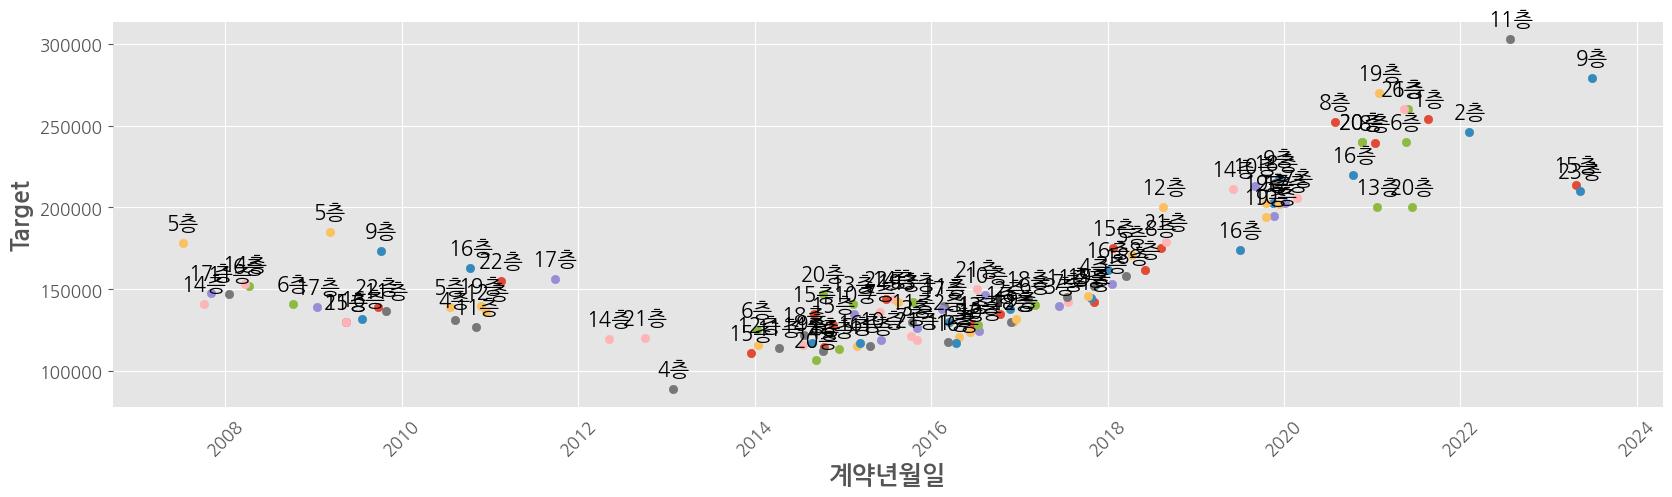

In [503]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 데이터 처리 부분
filtered = train_test[train_test.아파트명.str.contains('개포자이')==True]
show = filtered[['id', '계약년월일','target','is_test','층']]
show['계약년월일'] = pd.to_datetime(show['계약년월일'])  # 계약년월일을 datetime 객체로 변환

# 그래프 그리기 부분
plt.figure(figsize=(20, 5))

# 층별로 다른 색상과 선 스타일로 플롯
apartfloor = show.층.unique().max()
for floor in range(1, apartfloor + 1):  # 층 범위 수정: apartfloor + 1로 변경
    subset = show[(show.is_test == 0) & (show.층 == floor)]
    plt.scatter(subset['계약년월일'], subset['target'], label=f'층 {floor}')  # scatter로 변경

    # 각 데이터 포인트에 주석 추가
    for i in range(len(subset)):
        plt.annotate(f'{floor}층', (subset['계약년월일'].iloc[i], subset['target'].iloc[i]), 
                     textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)  # 그리드 활성화
plt.xticks(rotation=45)  # x축 레이블 회전
plt.xlabel('계약년월일')  # x축 레이블
plt.ylabel('Target')  # y축 레이블


### 구마다 아파트 평균 가격이 다르다

In [510]:
gu = train_test.구.unique()
gu

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [520]:
train_test.계약년월일.min()
train_test.계약년월일.max()

Timestamp('2023-09-26 00:00:00')

C:\Users\user\AppData\Local\Temp\ipykernel_22368\1761913101.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


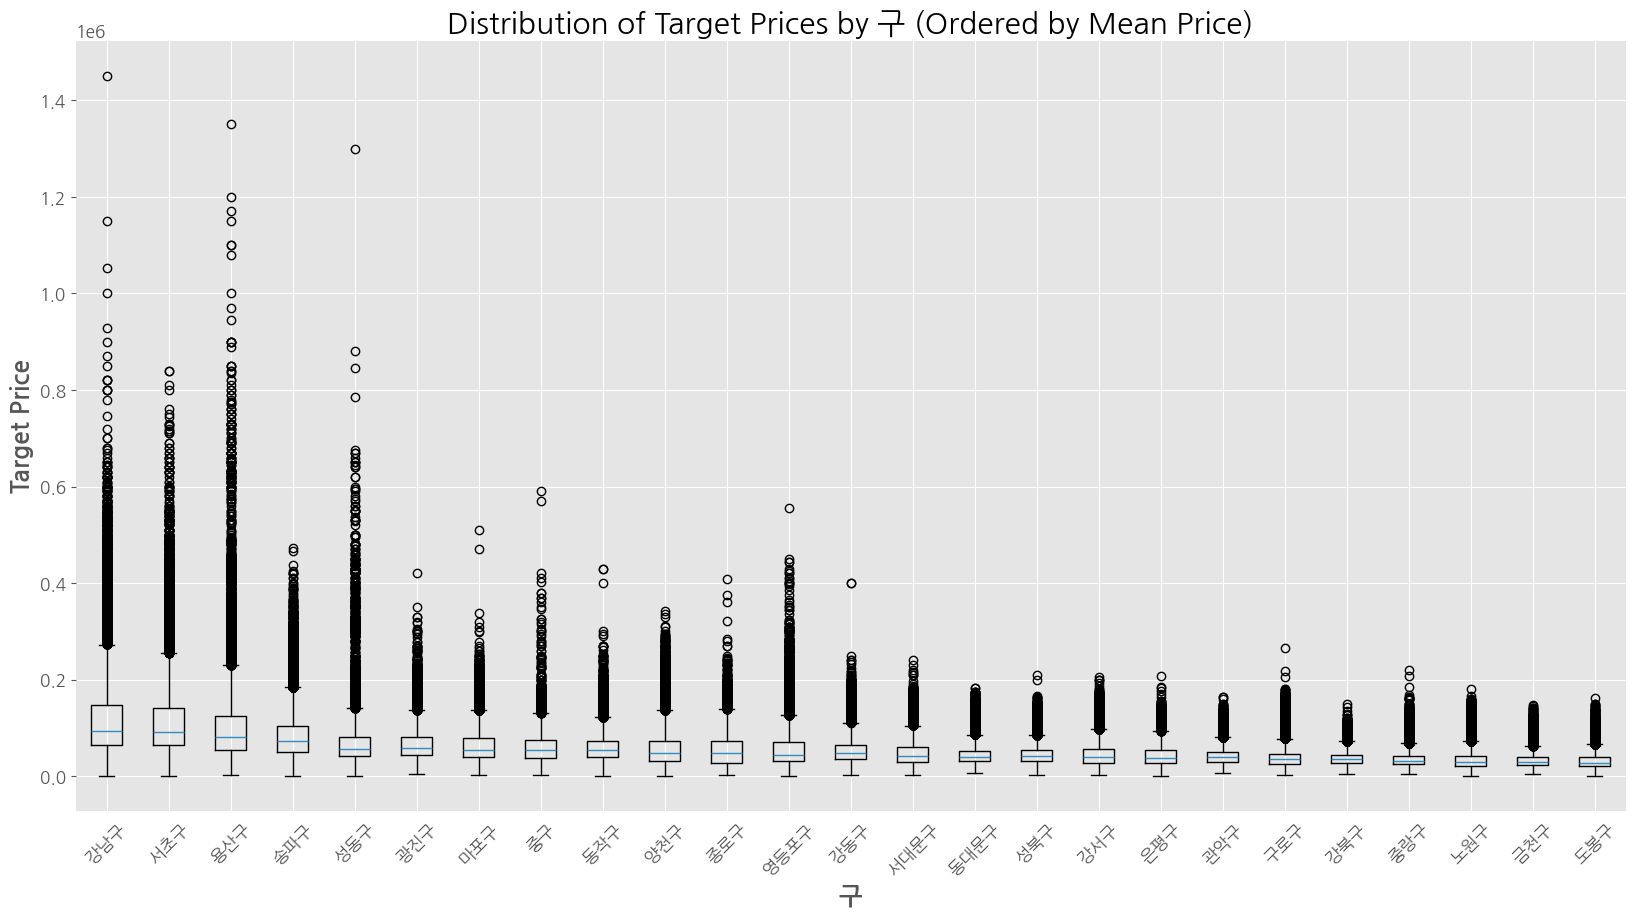

In [523]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
train_test['계약년월일'] = pd.to_datetime(train_test['계약년월일'])
filtered_df = train_test[(train_test['계약년월일'] >= '2007-01-01') & (train_test['계약년월일'] <= '2023-06-30')]

# '구'별로 평균 'target'을 계산하고 정렬
mean_targets = filtered_df.groupby('구')['target'].mean().sort_values(ascending=False)
sorted_gus = mean_targets.index  # 정렬된 '구' 목록

# 박스플롯 데이터 준비
boxplot_data = [filtered_df[filtered_df['구'] == gu]['target'] for gu in sorted_gus]

# 박스플롯 생성
plt.figure(figsize=(20, 10))
plt.boxplot(boxplot_data, labels=sorted_gus)
plt.xticks(rotation=45)  # x축 레이블 회전
plt.xlabel('구')
plt.ylabel('Target Price')
plt.title('Distribution of Target Prices by 구 (Ordered by Mean Price)')
plt.grid(True)
plt.show()
